# StatusToday Project

## Loading the data

In [1]:
%matplotlib inline

import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

plt.rcParams['figure.figsize'] = 15,10
plt.rcParams['font.size'] = 14
np.random.seed(0)

In [2]:
df = pd.read_csv('../data/exercise.csv')

## Hold-out Dataset

In order to validate the final performance, a small partition of the data will be kept untouched.

In [3]:
len(df)

1429

The data is very small, so, instead of the usual 0.7/0.3 train/test split, I will use only 0.2 of the data for test. This takes in consideration that the train data may also be split in a train/validation manner.

Using `sklearn.model_selection.train_test_split()` to make sure the dataframe is randomised before splitting to avoid possible order confounds. The function also allows us to stratify it on split, but, for this exercise, I will avoid this so the test set looks more similar to a real world test where classes are likely imbalanced.

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=0)

## Data Exploration

In [5]:
train.describe()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Class
count,1128.000000,1138.000000,1130.000000,1136.000000,1134.000000,1127.000000,1134.000000,1126.000000,1135.000000,1132.000000,1143.000000
mean,2.761482,18.835952,-9.574803,9.983717,13.777209,-18.585281,-16.727119,-22.516695,-0.927062,9.948885,0.371829
std,0.091941,0.066747,0.229120,0.251615,1.521873,0.509294,9.274187,0.028943,0.325220,0.424079,0.483504
min,2.140701,18.043017,-10.471220,9.148813,9.178957,-20.810481,-45.823666,-23.147576,-2.063484,8.928247,0.000000
25%,2.741825,18.841566,-9.690766,9.865447,12.810516,-18.841014,-23.298961,-22.515233,-1.106257,9.663847,0.000000
50%,2.810525,18.841566,-9.612721,10.008774,13.687099,-18.432257,-16.491196,-22.515233,-0.890881,9.921471,0.000000
75%,2.810525,18.841566,-9.495653,10.152101,14.688909,-18.227878,-10.454935,-22.515233,-0.699436,10.178898,1.000000
max,2.999449,18.841566,-7.622564,11.413376,20.073634,-17.614742,8.135920,-22.515233,-0.005447,11.401405,1.000000


Please note that exact numbers may differ depending on the initial sample

- **Dataset size:** From above, we can see that there are 9 features and 1,143 data points (`1143x9` data). This is a small dataset which means that deep learning is likely unnecessary, and decision trees or even logistic regression may do the job.
- **Missing values:** The `count` row shows that, in fact, there are no columns where no data point is missing (i.e. all are lower than the `count` for `Class`). However, there are at most 18 values missing for a feature, which makes for $\approx 0.012%$ missing values. This may indicate that imputation is not necessary or using the mean (or discarding the data) may be sufficient.
- **Class imbalance:** The `mean` row combined with the `Class` column shows us that classes are not perfectly balanced: $\approx 37\%$ of the data belongs to class `1`, and the rest of $\approx 63\%$ of the data belongs to class `0`. This may be useful insight when applying cross-validation, as stratified CV may be preferable.
- **Constant features:**
  - The `std` row shows us that columns such as `Feature_0`, `Feature_1`, and `Feature_7` have very little variation and they may be almost constant among samples, thus of low predictive power. This needs to be investigated furter.
  - The percentiles show us that features such as `Feature_1` and `Feature_7` are nearly constant, and it should be kept in mind that we may transform them in a binary column.
  
  
### Constant columns

In [6]:
train.head()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Class
1352,2.810525,18.841566,-9.534676,9.521463,14.563683,-18.283618,-18.433329,-22.515233,-0.675505,9.777620,1
1325,2.664538,18.841566,-9.456630,9.865447,12.685290,-18.283618,4.809828,-22.515233,-0.412268,9.300945,0
299,2.784762,18.841566,-9.651744,9.750786,15.315040,-18.060659,-19.526271,-22.515233,-1.249841,10.367855,0
420,2.810525,18.841566,-9.729789,10.008774,14.563683,-19.992967,-14.275344,-22.515233,-0.819089,9.862301,1
513,2.810525,18.841566,-9.690766,9.894112,13.060968,-18.432257,-27.965517,-22.515233,-1.010535,9.902517,0


Taking a peek at the dataset reveals that, indeed, some columns may have constant values. Now, in order to get a more descriptive view about this:

In [7]:
train.apply(lambda x: x.nunique())

Feature_0      65
Feature_1       2
Feature_2      45
Feature_3      52
Feature_4      74
Feature_5      74
Feature_6    1134
Feature_7       3
Feature_8      80
Feature_9    1132
Class           2
dtype: int64

The table above reveals that although the data appears to be continuous, many of the columns may be considered discrete. For some it may be helpful to take an even closer look:

In [8]:
print(train['Feature_1'].value_counts())
print(train['Feature_7'].value_counts())

18.841566    1130
18.043017       8
Name: Feature_1, dtype: int64
-22.515233    1123
-23.147576       2
-22.896163       1
Name: Feature_7, dtype: int64


`Feature_7` has 1,124 identical values and 3 different values. Those 3 different values are likely not enough to help a model learn a pattern and may introduce noise. Before removing both `Feature_1` and `Feature_7`, I'll check if all 7 rows where `Feature_7 == 18.043017` happen to map to the same class:

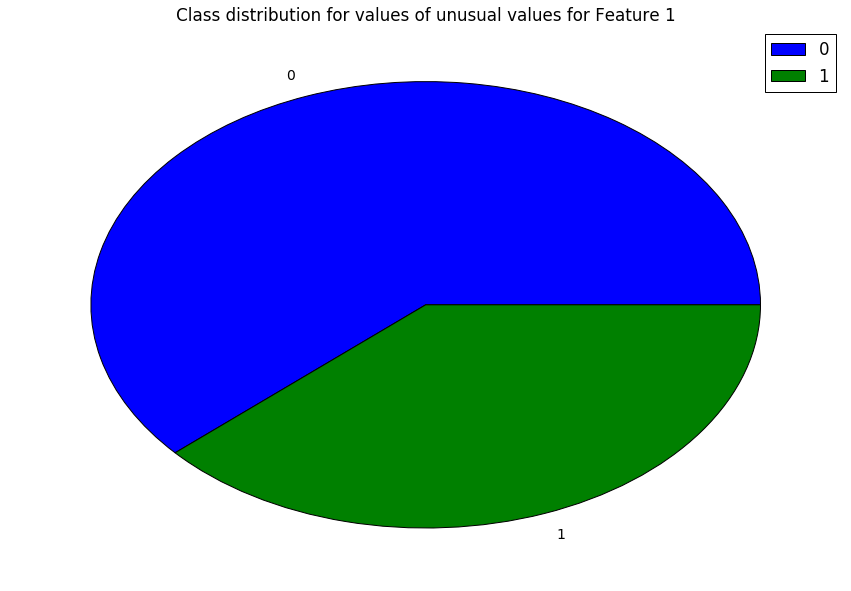

In [9]:
items = list(train[train['Feature_1'] != float(train['Feature_1'].mode())]['Class'])
plt.pie([len(items) - sum(items), sum(items)], labels=['0', '1'])
plt.legend()
plt.title('Class distribution for values of unusual values for Feature 1')
plt.show()

No clear pattern could be distinguished from this brief survey, so both columns will be dropped to reduce noise:

In [10]:
def drop_cols(col_names, train, test):
    """Delete column for both train and test dataframes"""
    for col_name in col_names:
        train = train.drop(col_name, axis=1)
        test = test.drop(col_name, axis=1)
    return train, test

train, test = drop_cols(['Feature_1', 'Feature_7'], train, test)

### Missing values

How many missing values are there for each feature?

In [11]:
train.apply(lambda x: x.isnull().sum())

Feature_0    15
Feature_2    13
Feature_3     7
Feature_4     9
Feature_5    16
Feature_6     9
Feature_8     8
Feature_9    11
Class         0
dtype: int64

Not too many, considering there are almost 1,500 datapoints.

Do missing values say anything about a class?

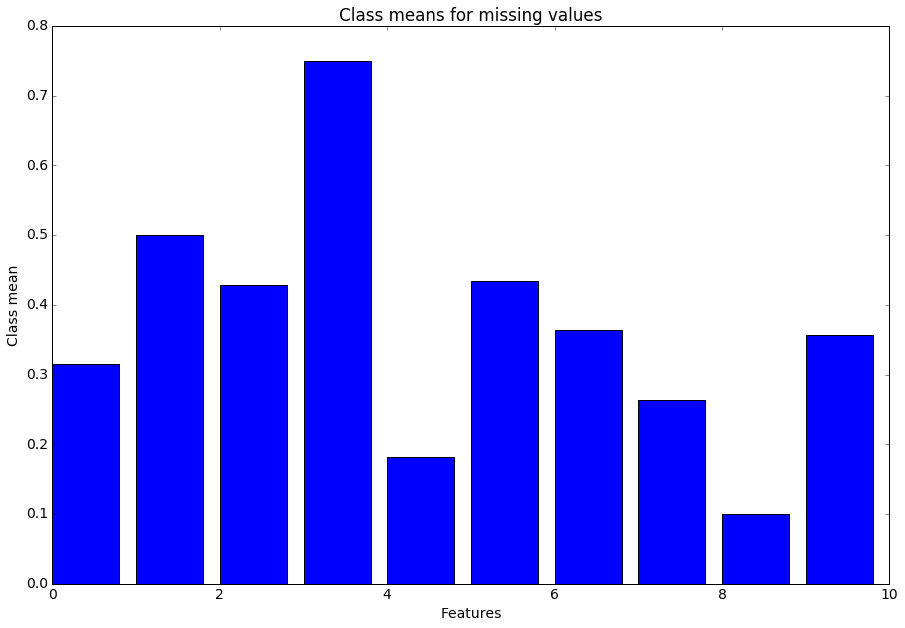

In [12]:
plt.bar(range(11), [df[df[feature].isnull()]['Class'].mean() for feature in df.columns])
plt.xlabel('Features')
plt.ylabel('Class mean')
plt.title('Class means for missing values')
plt.show()

Nothing particularly obvious.

How many rows would we lose if we discard data with missing features? Some rows may have multiple missing values.

In [13]:
n_rows = len(train[train.isnull().any(axis=1)])
print('Rows with missing value(s):', n_rows)
print('In percentages {:.1%}:'.format(n_rows/len(train)))

Rows with missing value(s): 87
In percentages 7.6%:


Removing $9.4\%$ from an already small dataset may not be a good idea.

Is there anything unusual about these rows?

In [14]:
print('Class mean for the data subset where values are missing:',
      round(train[train.isnull().any(axis=1)]['Class'].mean(), 3))
print('Class mean for the data where no values are missing:',
      round(train[~train.isnull().any(axis=1)]['Class'].mean(), 3))

Class mean for the data subset where values are missing: 0.345
Class mean for the data where no values are missing: 0.374


The classes seem to be similarly distributed for the missing rows as they are for the entire `train` dataframe. Plus, one should consider that there are 115 missing values, and 100 of them happen on independent rows. Therefore, there may not be a specific pattern for why data is missing (i.e. the deletions were random), so imputting the mean may be a good idea.

In [15]:
train.fillna(train.mean(), inplace=True);
test.fillna(train.mean(), inplace=True); # Fill test with train.mean() as well

## Basic Checking

Now that the data has no missing values, before hunting for more insight into the data, we can setup a simple algorithm to see if we actually need to look further into the data.

In [16]:
from sklearn.linear_model import LogisticRegressionCV

In [17]:
def check_lr(train):
    X, y = train.drop('Class', axis=1), train['Class']

    lr = LogisticRegressionCV(
        scoring='roc_auc', # Different metrics may be used.
                           # For instance area under the precision-recall curve or F1-score
        cv=5, # calls StratifiedKFold by default
        random_state=0, # for reproducibility
    )
    lr.fit(X, y)
    print('AUROC (best mean from all folds):', lr.scores_[1].mean(axis=1).max())
    return X, y

X, y = check_lr(train)

AUROC (best mean from all folds): 0.869836601307


The area under the ROC curve for logistic regression is quite high, even if logistic regression is a linear classifier. It may be the case that there aren't any significant nonlinear relationships between features, and some may even be unnecessary. 

### Feature Importance

We can verify feature importance using decision trees, as trees have various way of estimating importance. CART algorithms use Gini impurity as a performance metric and it can be quantified how much a feature helps us reduce impurity.

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees = ExtraTreesClassifier() # Uses Gini impurity by default

extra_trees.fit(X, y)
indices = np.argsort(extra_trees.feature_importances_)[::-1]

# Print the feature ranking
print("Feature importances:")
for index in indices:
    print('{}: {}'.format(X.columns[index], extra_trees.feature_importances_[index]))

Feature importances:
Feature_3: 0.2588895252182476
Feature_5: 0.1700800335176481
Feature_4: 0.1331895259562927
Feature_9: 0.11685542513805833
Feature_8: 0.10109256951590824
Feature_2: 0.07936791941864828
Feature_6: 0.07032455713334693
Feature_0: 0.07020044410184982


We can see that `Feature_6`, `Feature_2`, `Feature_8`, `Feature_9`, and `Feature_0` add very little contribution to our result, and thus they may be noisy variables. We will drop them and recheck the AUROC for LR.

In [19]:
train, test = drop_cols(['Feature_6', 'Feature_2', 'Feature_0', 'Feature_8', 'Feature_9'], train, test)
X, y = check_lr(train)

AUROC (best mean from all folds): 0.871503267974


It can be observed that our prediction score increased without the 5 features we just removed, and thus they were either noisy or they were modelling nonlinear relationships . A more detailed analysis could be performed at this point to check the CV scores for each missing feature, but it may be unnecessary at this point.

## Final Model

At this point, the performance of the model may be improved through several methods:
- One may try to engineer nonlinear features; however, given that the featuers are anonymised, it would be a brute-force effort.
- A nonlinear model may be used such as RandomForest, SVM with a nonlinear kernel, and even an MLP.
- A search may be performed in the hyperparameter space to find the best suited learning parameters. For this case, random search may be attempted, as it was shown that grid search is relatively ineffective [1].
- Lastly, an ensemble of models may be built to optimise the performance

However, for this exercise, given that performance is not crucial, and the logistic regression provides reasonable results, I will stick to this.

[1] Bergstra, James, and Yoshua Bengio. "Random search for hyper-parameter optimization." Journal of Machine Learning Research 13.Feb (2012): 281-305.

## Evaluation

For evaluation, multiple metrics will be considered. I will use the test dataset I reserved from the beginning and calculate several metrics.

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression() # Default hyperparameters
lr.fit(X, y)

X_test, y_test = test.drop('Class', axis=1), test['Class']

y_prob = lr.predict_proba(X_test)[:, 1] # Probabilities
y_pred = lr.predict(X_test) # Predictions

### Accuracy

Accuracy is computed as $\frac{TP + TN}{TP + TN + FP + FN}$ -- in other words, what proportion of the data has been correctly classified?

In [21]:
from sklearn import metrics

print(metrics.accuracy_score(y_test, y_pred))

0.821678321678


Accuracy by itself is not very informative--particularly, a naive model may output a constant (either 1 or 0) and obtain:

In [22]:
max(y_test.mean(), 1 - y_test.mean())

0.60839160839160833

This slight deviation from `0.5` is caused by the class imbalance.

### Confusion Matrix

In [23]:
print(metrics.confusion_matrix(y_test, y_pred))

[[158  16]
 [ 35  77]]


From above, we can tell that $TP=77$, $TN=158$, $FP=16$, and $FN=35$. From here we may want to calculate metrics such as the sensitivity/specificity/precision and reason which ones should be prioritised according to the business needs. From here, we could adjust the threshold from the default of $0.5$ to accommodate a balance of FP/FN.

### F1-score

Further, recall and precision along with a balanced F-measure is computed to provide further insight into how the algorithm performs. 

In [24]:
print('Recall: {}'.format(round(metrics.recall_score(y_test, y_pred), 2)))
print('Precision: {}'.format(round(metrics.precision_score(y_test, y_pred),2 )))
print('F1-score: {}'.format(round(metrics.f1_score(y_test, y_pred), 2)))

Recall: 0.69
Precision: 0.83
F1-score: 0.75


Depending on the business needs, precision or recall may be prioritised higher.

### ROC curve

Finally, the ROC curve may be used to select a threshold that accounts for business requirements related to sacrificing FP or FN.

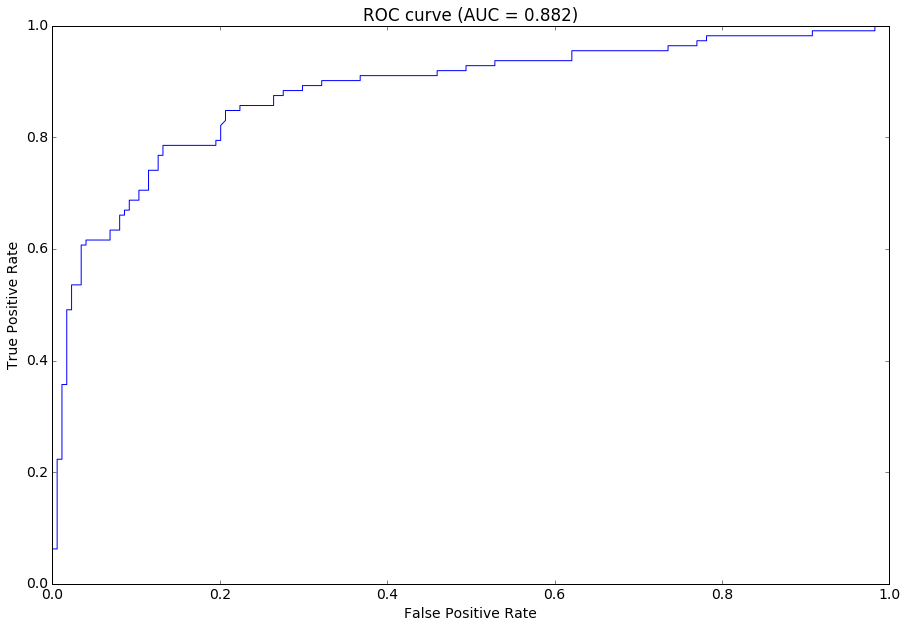

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
auroc = metrics.roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr)
plt.title('ROC curve (AUC = {:.3})'.format(auroc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

It can be seen from above that we can sacrifice a high true positive rate to obtain better recall or the other way around. For instance, we can check some threshold values:

In [26]:
def assess_threshold(threshold):
    print('For threshold {}'.format(threshold))
    print('True Positive Rate: {:.2} \nTrue Negative Rate: {:.2}\n\n'.format(
           tpr[thresholds > threshold][-1], 1 - fpr[thresholds > threshold][-1]))
    
assess_threshold(0.1)
assess_threshold(0.9)
assess_threshold(0.5)

For threshold 0.1
True Positive Rate: 0.96 
True Negative Rate: 0.34


For threshold 0.9
True Positive Rate: 0.062 
True Negative Rate: 0.99


For threshold 0.5
True Positive Rate: 0.69 
True Negative Rate: 0.91




For this problem, without further context, we will assume the default `0.5` threshold value. This value provides a high specifity (90%) and moderate recall (69%). This means we will have very few false positives, but we may missclassify about 30% of data points of `Class = 1` as being of `Class = 0`.

## Save Model

In [27]:
from sklearn.externals import joblib
joblib.dump(lr, '../data/model.pkl')
# Also save the means of the columns we kept so we can handle missing valuetp
with open('../data/means.pkl', 'wb') as f:
    pickle.dump(train.drop('Class', axis=1).mean().to_dict(), f)